# Problem Statement

Fradulent Medicare claims is a serious problem impacting the healthcare industry. The purpose of this project is to build a predictive model to detect such claims and help insurance companies to act on those.

# Project Structure

- Data Understading
- Data Prepration
- Exploratory Data Analysis & Feature Engineering
- Modelling
- Model Evaluation
- Deployment

# Data Understanding

As a first step, all sample files will be imported into data frames and preliminary analysis is done.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

sns.set(rc={"figure.figsize":(10, 5)})

In [63]:
file_path="./fraud_data"
in_patient=f"{file_path}/Train_Inpatientdata-1542865627584.csv"
out_patient=f"{file_path}/Train_Outpatientdata-1542865627584.csv"
bene=f"{file_path}/Train_Beneficiarydata-1542865627584.csv"
labelled=f"{file_path}/Train-1542865627584.csv"

In [64]:
df_in = pd.read_csv(in_patient)
df_out = pd.read_csv(out_patient)
df_bene = pd.read_csv(bene)
df_lab = pd.read_csv(labelled)

# Data Preparation

## **Labelled data**

In [65]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

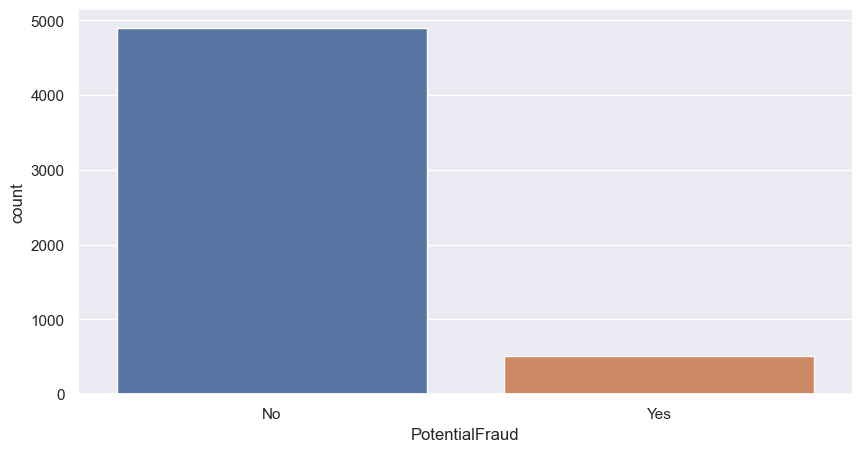

In [66]:
sns.countplot(x='PotentialFraud', data=df_lab)

## **Inpatient data**

**Convert datatypes**

In [67]:
df_in['ClaimStartDt'] = pd.to_datetime(df_in['ClaimStartDt'], infer_datetime_format=True)
df_in['ClaimEndDt'] = pd.to_datetime(df_in['ClaimEndDt'], infer_datetime_format=True)
df_in['claim_duration'] = (df_in['ClaimEndDt'] - df_in['ClaimStartDt']).dt.days

In [68]:
df_in['AttendingPhysician'] = df_in['AttendingPhysician'].fillna("None")
df_in['OperatingPhysician'] = df_in['OperatingPhysician'].fillna("None")
df_in['OtherPhysician'] = df_in['OtherPhysician'].fillna("None")

In [69]:
# df_in['AttendingPhysician'] = df_in['AttendingPhysician'].astype(pd.StringDtype())

# not-working
for col in df_in.columns: 
    if df_in[col].dtype == 'object':
        df_in[col] = df_in[col].astype('str')

In [70]:
df_in_corr = df_in.loc[:, ['InscClaimAmtReimbursed',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4','ClmProcedureCode_5']
                             ].corr()
df_in_corr = round(df_in_corr.corr(), 2)

In [71]:
# sns.heatmap(df_in_corr, annot=True)

**Merge labelled data with inpatient data**

In [72]:
df_in = df_in.merge(df_lab, how='left', left_on='Provider', right_on='Provider')

<AxesSubplot:>

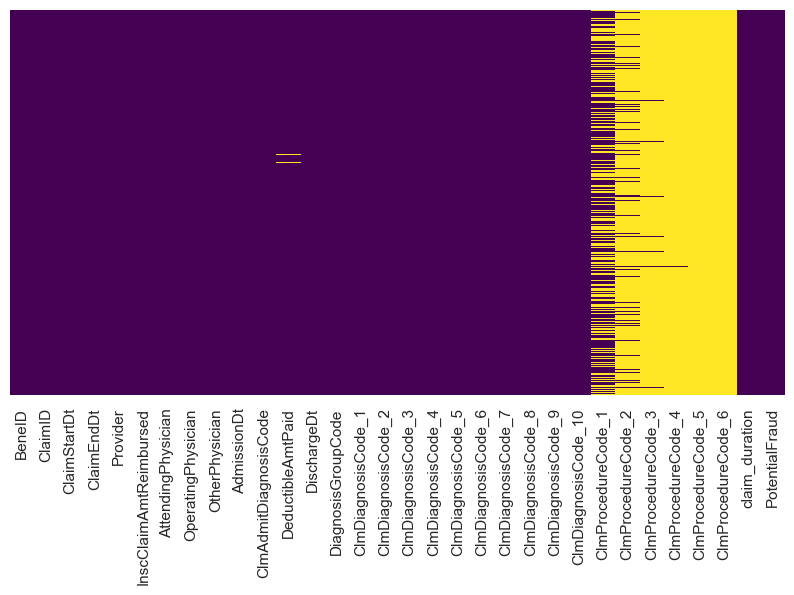

In [73]:
sns.heatmap(df_in.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**Create provider bins**

In [74]:
tmp = df_in.groupby(['Provider']).size()
tmp.name = 'Provcnt'

In [75]:
df_in_new = pd.merge(df_in, tmp, left_on = 'Provider', right_index=True)

In [76]:
bins = pd.cut(df_in_new.Provcnt, bins=4, labels=['low', 'med', 'high', 'top'])

In [77]:
bins.value_counts()

low     31732
med      6961
high     1265
top       516
Name: Provcnt, dtype: int64

In [78]:
df_in_new[df_in_new['Provider'] == 'PRV52019']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,claim_duration,PotentialFraud,Provcnt
46,BENE11153,CLM44063,2009-03-25,2009-03-27,PRV52019,3000,PHY351641,PHY351641,None,2009-03-25,...,V4364,NaN,NaN,NaN,NaN,NaN,NaN,2,Yes,516
177,BENE11670,CLM37086,2009-02-05,2009-02-08,PRV52019,400,PHY416959,None,None,2009-02-05,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,3,Yes,516
270,BENE11998,CLM62318,2009-08-03,2009-08-07,PRV52019,6000,PHY355567,PHY355567,PHY416093,2009-08-03,...,nan,5101.0,4019.0,NaN,NaN,NaN,NaN,4,Yes,516
437,BENE12624,CLM50035,2009-05-06,2009-05-10,PRV52019,7000,PHY395933,None,None,2009-05-06,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,4,Yes,516
452,BENE12699,CLM57568,2009-06-29,2009-06-30,PRV52019,5000,PHY401599,None,None,2009-06-29,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,Yes,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40163,BENE158096,CLM56081,2009-06-17,2009-06-27,PRV52019,6000,PHY412022,PHY354694,None,2009-06-17,...,nan,8843.0,NaN,NaN,NaN,NaN,NaN,10,Yes,516
40185,BENE158173,CLM79948,2009-12-17,2009-12-21,PRV52019,7000,PHY384309,PHY384309,None,2009-12-17,...,nan,8703.0,NaN,NaN,NaN,NaN,NaN,4,Yes,516
40200,BENE158221,CLM62646,2009-08-05,2009-08-08,PRV52019,2000,PHY414382,PHY406681,None,2009-08-05,...,nan,8872.0,NaN,NaN,NaN,NaN,NaN,3,Yes,516
40305,BENE158590,CLM52889,2009-05-26,2009-05-27,PRV52019,5000,PHY393952,PHY393952,None,2009-05-26,...,nan,64.0,NaN,NaN,NaN,NaN,NaN,1,Yes,516


In [79]:
df_in_new[bins=='top']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,claim_duration,PotentialFraud,Provcnt
46,BENE11153,CLM44063,2009-03-25,2009-03-27,PRV52019,3000,PHY351641,PHY351641,None,2009-03-25,...,V4364,NaN,NaN,NaN,NaN,NaN,NaN,2,Yes,516
177,BENE11670,CLM37086,2009-02-05,2009-02-08,PRV52019,400,PHY416959,None,None,2009-02-05,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,3,Yes,516
270,BENE11998,CLM62318,2009-08-03,2009-08-07,PRV52019,6000,PHY355567,PHY355567,PHY416093,2009-08-03,...,nan,5101.0,4019.0,NaN,NaN,NaN,NaN,4,Yes,516
437,BENE12624,CLM50035,2009-05-06,2009-05-10,PRV52019,7000,PHY395933,None,None,2009-05-06,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,4,Yes,516
452,BENE12699,CLM57568,2009-06-29,2009-06-30,PRV52019,5000,PHY401599,None,None,2009-06-29,...,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,Yes,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40163,BENE158096,CLM56081,2009-06-17,2009-06-27,PRV52019,6000,PHY412022,PHY354694,None,2009-06-17,...,nan,8843.0,NaN,NaN,NaN,NaN,NaN,10,Yes,516
40185,BENE158173,CLM79948,2009-12-17,2009-12-21,PRV52019,7000,PHY384309,PHY384309,None,2009-12-17,...,nan,8703.0,NaN,NaN,NaN,NaN,NaN,4,Yes,516
40200,BENE158221,CLM62646,2009-08-05,2009-08-08,PRV52019,2000,PHY414382,PHY406681,None,2009-08-05,...,nan,8872.0,NaN,NaN,NaN,NaN,NaN,3,Yes,516
40305,BENE158590,CLM52889,2009-05-26,2009-05-27,PRV52019,5000,PHY393952,PHY393952,None,2009-05-26,...,nan,64.0,NaN,NaN,NaN,NaN,NaN,1,Yes,516


In [80]:
df_in.PotentialFraud.value_counts()

Yes    23402
No     17072
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

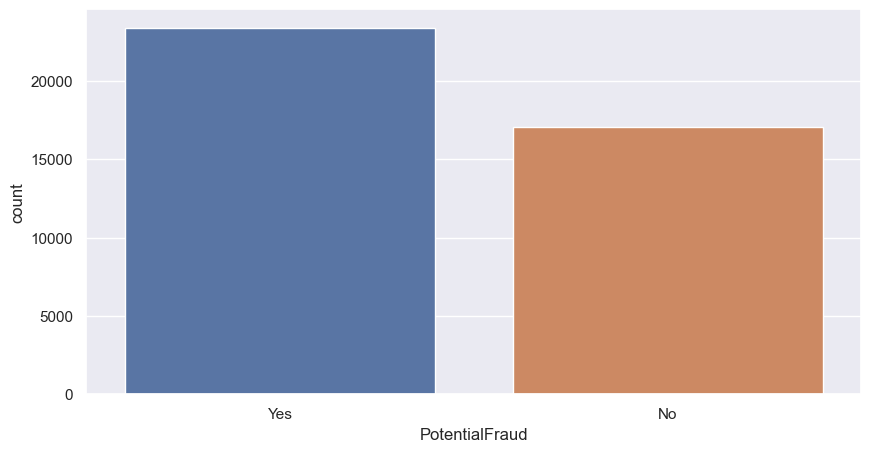

In [148]:
sns.countplot(x='PotentialFraud', data=df_in)

## **Outpatient data**

In [130]:
df_out['ClaimStartDt'] = pd.to_datetime(df_out['ClaimStartDt'], infer_datetime_format=True)
df_out['ClaimEndDt'] = pd.to_datetime(df_out['ClaimEndDt'], infer_datetime_format=True)
df_out['claim_duration'] = (df_out['ClaimEndDt'] - df_out['ClaimStartDt']).dt.days

In [149]:
df_out.PotentialFraud.value_counts()

No     328343
Yes    189394
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

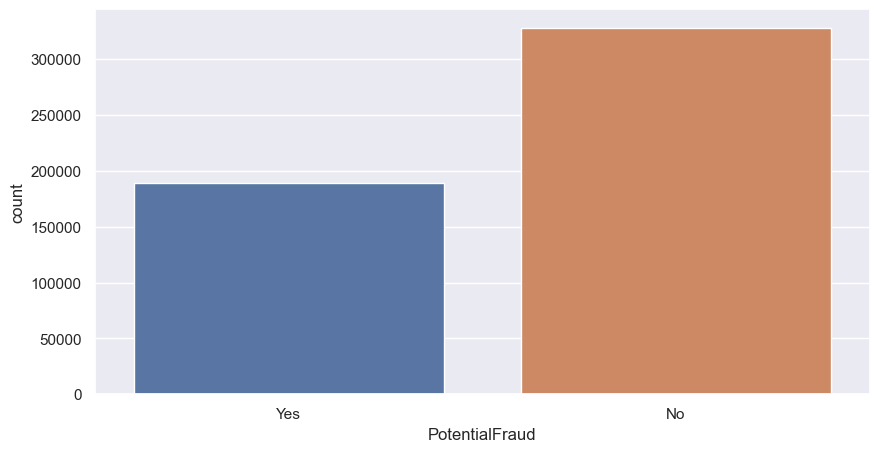

In [147]:
sns.countplot(x='PotentialFraud', data=df_out)

In [81]:
df_out_corr = df_out.loc[:, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4']
                             ].corr()
# df_out_corr = round(df_out_corr, 2)

In [82]:
# sns.heatmap(df_out_corr, annot=True)

**Merge labelled data with outpatient data**

In [83]:
df_out = df_out.merge(df_lab, how='left', left_on='Provider', right_on='Provider')

In [84]:
df_out['AttendingPhysician'] = df_out['AttendingPhysician'].fillna("None")
df_out['OperatingPhysician'] = df_out['OperatingPhysician'].fillna("None")
df_out['OtherPhysician'] = df_out['OtherPhysician'].fillna("None")

<AxesSubplot:>

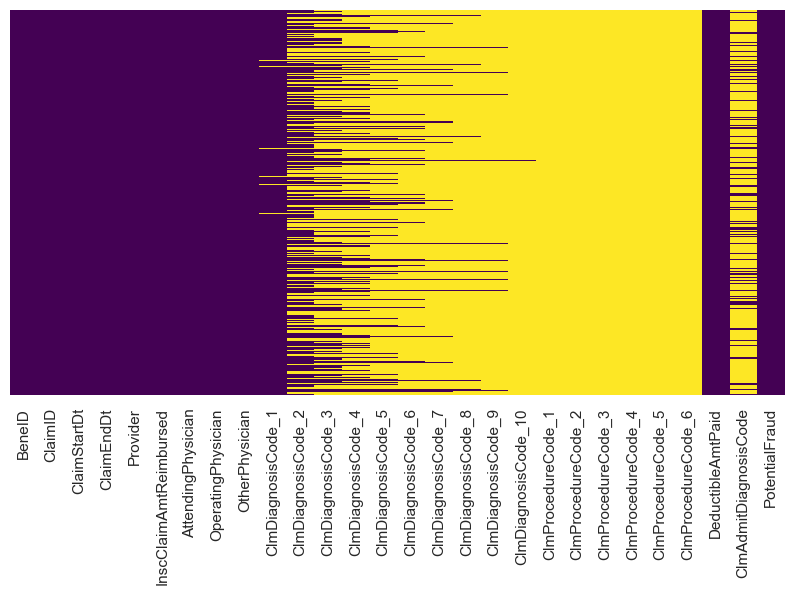

In [85]:
sns.heatmap(df_out.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## **Beneficiary data**

<AxesSubplot:>

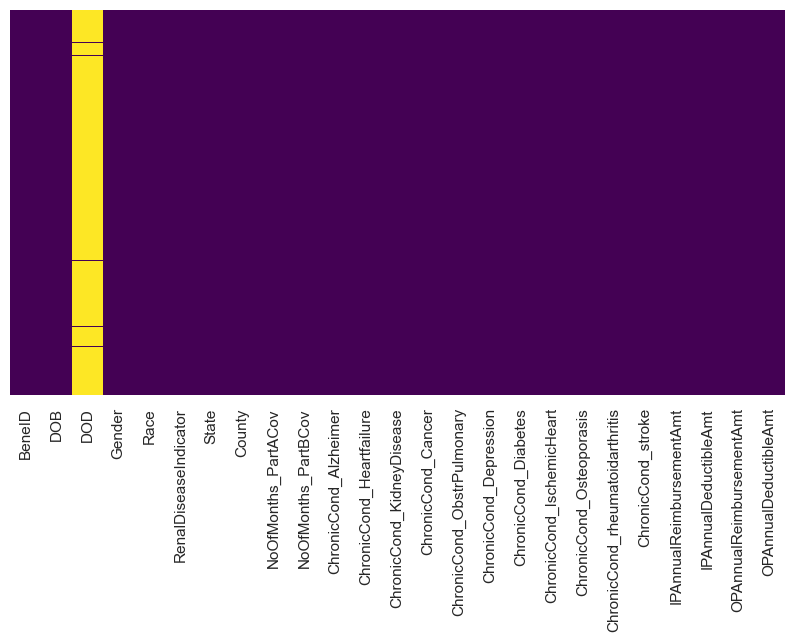

In [86]:
sns.heatmap(df_bene.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [87]:
df_bene['DOB'] = pd.to_datetime(df_bene['DOB'], format = '%Y-%m-%d')
df_bene['DOD'] = pd.to_datetime(df_bene['DOD'], format = '%Y-%m-%d')

***Age***

The max DOD date is 2009-01-12. This is used to fillin NaN values to cacluate age of beneficiary.

In [88]:
df_bene['DOD'].fillna("2009-12-01", inplace=True)
df_bene['Age'] = df_bene['DOD'].dt.year - df_bene['DOB'].dt.year

In [89]:
# sns.heatmap(df_bene_corr, annot=True)

In [90]:
bene_age_tier = [
    (df_bene['Age'] <= 30),
    (df_bene['Age'] > 30) & (df_bene['Age'] <= 45),
    (df_bene['Age'] > 45) & (df_bene['Age'] <= 64),
    (df_bene['Age'] >= 65)
    ]

In [91]:
bene_age = df_bene['Age']
bene_age = np.select(bene_age_tier, ['Young', 'Early middle' ,'Late middle', 'Senior'])

<AxesSubplot:ylabel='count'>

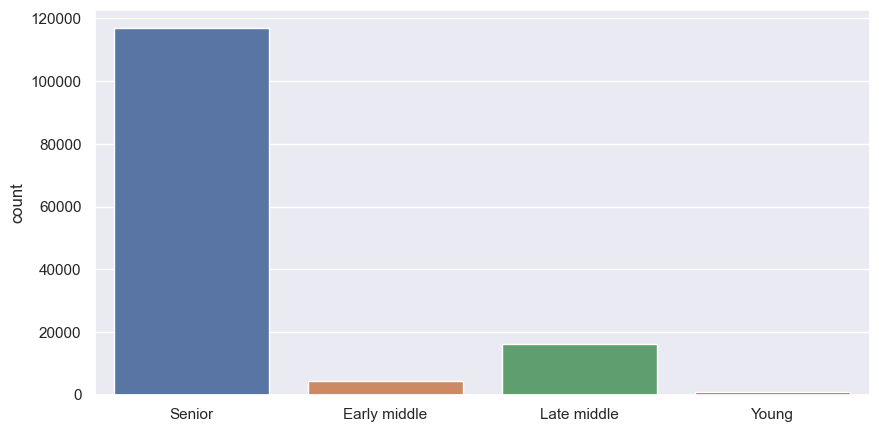

In [92]:
sns.countplot(x=bene_age)
#sns.countplot(x='Age', data=df_bene)

**Bene claimed as inpatient or outpatient**

In [93]:
df_bene['has_claimed_ip'] = df_bene['BeneID'].isin(df_in['BeneID'])
df_bene['has_claimed_op'] = df_bene['BeneID'].isin(df_out['BeneID'])

<AxesSubplot:xlabel='has_claimed_ip', ylabel='count'>

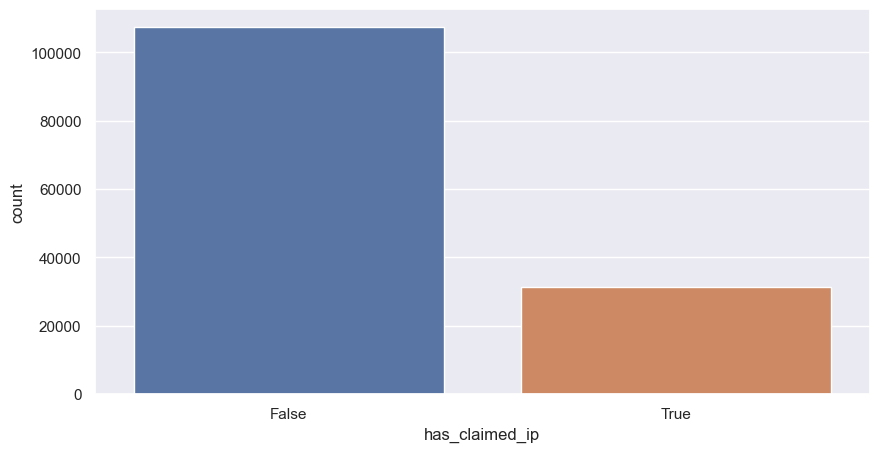

In [128]:
sns.countplot(x='has_claimed_ip', data=df_bene)

<AxesSubplot:xlabel='has_claimed_op', ylabel='count'>

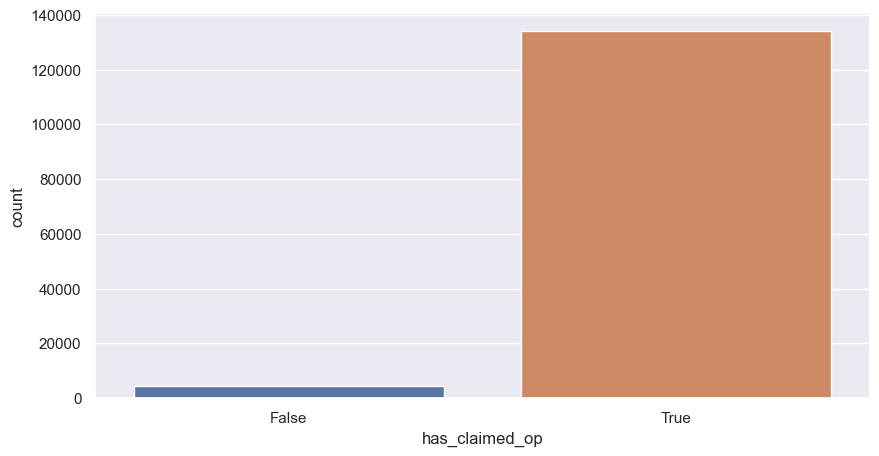

In [129]:
sns.countplot(x='has_claimed_op', data=df_bene)

**Merge beneficiaries with inpatient & outpatient data**

In [151]:
df_in = df_in.merge(df_bene, how='left', left_on='BeneID', right_on='BeneID')
df_out = df_out.merge(df_bene, how='left', left_on='BeneID', right_on='BeneID')

**One-Hot-Encoder**

In [96]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [97]:
enc_df = pd.DataFrame(encoder.fit_transform(df_in[['Provider']]).toarray())

In [98]:
enc_df

,0,1,2,3,4,5,6,7,8,9,...,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
tmp = df_in.groupby(['Provider']).size()
tmp.name = 'Provcnt'

In [100]:
# df_all_new = pd.merge(df_all, tmp, left_on = 'Provider', right_index=True)

In [101]:
# bins = pd.cut(df_in.Provcnt, bins=2, labels=['low', 'high'])

<AxesSubplot:xlabel='Gender', ylabel='count'>

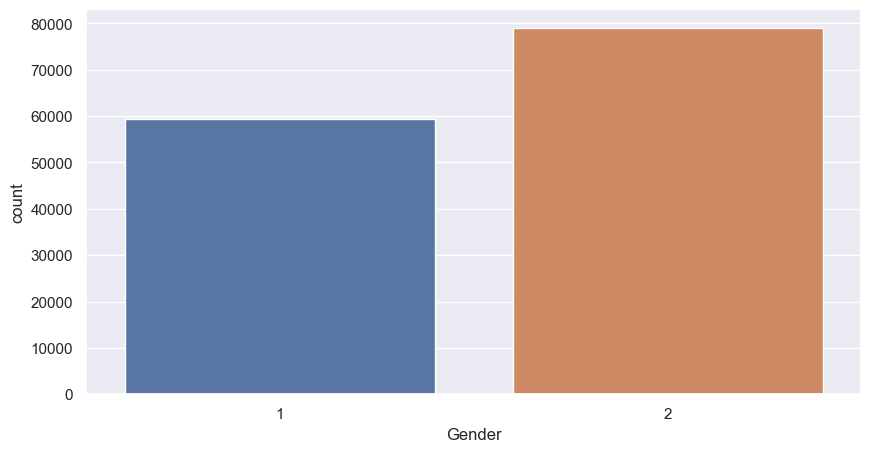

In [102]:
sns.countplot(x='Gender', data=df_bene)

# **Diseases**

**Alzheimers - inpatient**

In [112]:
df_in_bene_Alz = df_in[df_in['ChronicCond_Alzheimer'] == 1]

In [158]:
df_in_bene_Alz.PotentialFraud.value_counts()

Yes    11756
No      8645
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

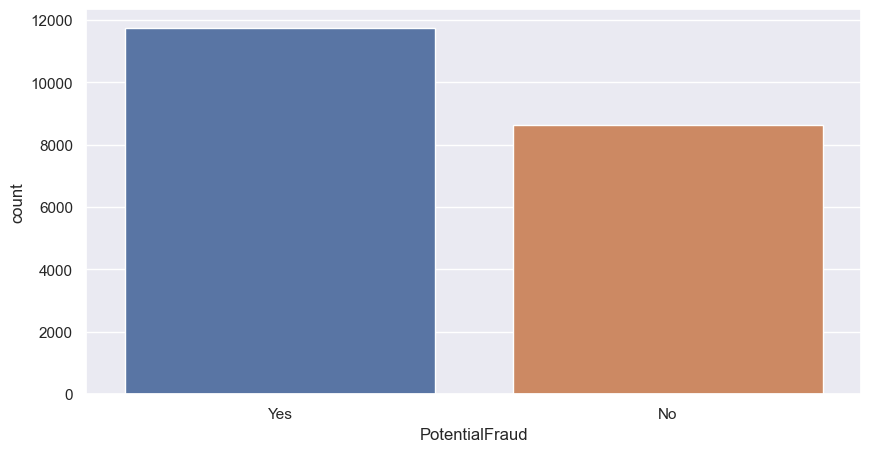

In [126]:
sns.countplot(x='PotentialFraud', data=df_in_bene_Alz)

**Alzheimers - outpatient**

In [153]:
df_out_bene_Alz = df_out[df_out['ChronicCond_Alzheimer'] == 1]

In [159]:
df_out_bene_Alz.PotentialFraud.value_counts()

No     129335
Yes     74591
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

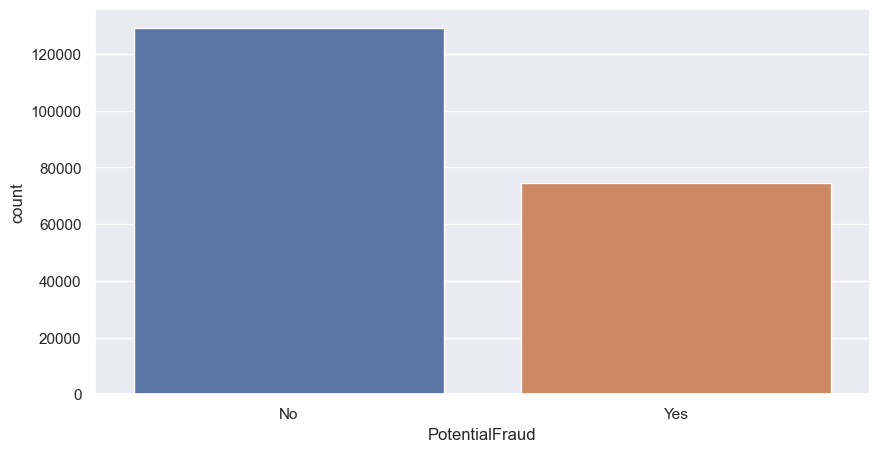

In [155]:
sns.countplot(x='PotentialFraud', data=df_out_bene_Alz)

# Exploratory Data Analysis

**Target Labels**

The target variable in the labelled dataset is "PotentialFraud" which indicates whether a provider is fradulent or not. Out of 5410 providers in total, 9.35% are fradulent.

<AxesSubplot:ylabel='PotentialFraud'>

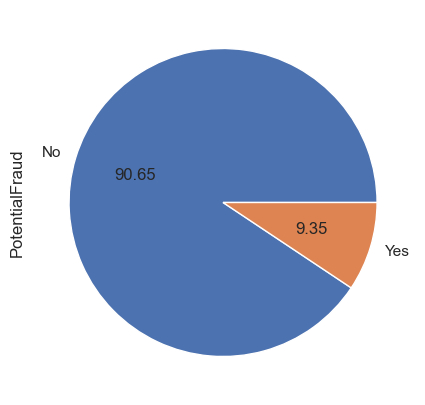

In [103]:
target = df_lab["PotentialFraud"]
target.value_counts().plot.pie(autopct='%.2f',figsize=(6, 5))

# Modeling